<a href="https://colab.research.google.com/github/tmwronski/route-planner/blob/master/Route_planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Route planner

Poniższy notebook prezentuje możliwość wyszukiwania i wizualizacji najkrótszej trasy z punktu A do B poprzez podane waypointy. Sieć dróg reprezentowana jest przez graf, natomiast do wyznaczania ścieżek został użyty algorytm Dijkstra.

Bazujemy na bibliotece [OSMnx](https://github.com/gboeing/osmnx), aby pobrać potrzebne dane z OpenStreetMap i odpowiednio je przetworzyć.

Google Colab nie ma tego modułu domyślnie zainstalowanego, dlatego należy zrobić to ręcznie. Dodatkowe zależności to [libspatialindex](https://libspatialindex.org/) oraz [Rtree](https://toblerity.org/rtree/). Google Colab bazuje na Ubuntu 18.04, dlatego libspatialindex można zainstalować bezpośrednio z repozytorium, a Rtree oraz OSMnx za pomocą menadżera pip.

In [ ]:
%%capture
!apt install libspatialindex-dev
!pip install rtree
!pip install osmnx

## Importowanie modułów


*   OSMnx i NetworkX do operacji na grafach
*   Matplotlib.cm do zmapowania kolorów potrzebnych do wizualizacji
*   Matplotlib.colors do uzyskania wbudowanych kolorów
*   Matplotlib.pyplot do wizualizacji

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Pobieranie grafu

Punkty początkowy, końcowy oraz wszystkie punkty pośrednie są przechowywane w jednej liście ```places```. Generalnie, kolejność punktów pośrednich nie ma znaczenia, ponieważ algorytm wyznaczy najkrótszą trasę pomiędzy nimi. Ważne jest tylko, aby punkt początkowy oraz końcowy były odpowiednio na pierwszym i ostatnim miejscu w liście.

Aby cały kod wykonał się w miarę szybko, lepiej jest wybrać punkty położone blisko siebie (np. w obrębie jednego miasta/ aglomeracji). Każdy punkt powinien mieć format zapytania OpenStreetMap.

Następnie potrzebujemy wyznaczyć współrzędne wszystkich punktów, aby wybrać wartości skrajne, poszerzyć je o 0.015 stopnia i pobrać ten obszar z OpenStreetMap w formie grafu.

Ponieważ interesuje nas sieć dróg, przekazujemy do funkcji parametr ```network_type="drive"```.

In [ ]:
places = [
    "Józefa Rostafińskiego 8, Kraków",
    "ICE, Kraków",
    "Galeria Krakowska, Kraków",
    "Muzeum Narodowe, Kraków",
    "Plac Inwalidów, Kraków",
    "Fabryka Schindlera, Kraków"
]

geocodes = [ox.geocode(place) for place in places]

max_geocodes = list(map(max, zip(*geocodes)))
min_geocodes = list(map(min, zip(*geocodes)))

north = max_geocodes[0] + 0.015
south = min_geocodes[0] - 0.015
east = max_geocodes[1] + 0.015
west = min_geocodes[1] - 0.015

G = ox.graph_from_bbox(north, south, east, west, network_type="drive")

## Wyznaczanie trasy

Aby wyznaczyć trasę potrzebujemy znaleźć węzły grafu, które są najbliżej naszych punktów. Wykorzystujemy do tego funkcję wbudowaną w OSMnx - ```get_nearest_node()```. Wykorzystuje ona formułę haversine, która bazuje na długości ortodromy pomiędzy dwoma punktami. Ponieważ do wizualizacji będziemy potrzebować współrzędnych znalezionych węzłów, a lista ```closest_nodes``` będzie modyfikowana, od razu je pobieramy.

Następnie zapisujemy punkt początkowy oraz końcowy. Zaczynamy tworzyć trasę, którą zaczynamy od punktu początkowego a ten punkt przypisujemy do zmiennej ```orig_node```.

Do wyznaczanie trasy używamy funkcji z NetworkX - ```get_shortest_path()```, która bazuje na algorytmie Dijkstra. Jako wagę przyjmuje ona długość krawędzi grafu.

Algorytm Dijkstra jest jednym z podstawowych algorytmów szukania połączenia między węzłami w grafie. Nie jest on jednak optymalny w przypadku bardzo dużych grafów, takich jak sieci dróg. Do tego celu zostały stworzone bardziej zaawansowane algorytmy np. hub labeling lub ALT (A* search, landmarks, and triangle inequality). Ich implementacja jest jednak skomplikowana a Dijkstra zupełnie wystarcza do naszych potrzeb.

Dodatkowo, algorytm Dijkstra znajduje ścieżkę tylko między dwoma węzłami. Możemy jednak wyznaczać trasy pomiędzy kolejnymi punktami oddzielnie i złożyć to w jedną.

### Nasz algorytm

1.   Dopóki ```closest_nodes``` nie jest pusta, określ długość trasy pomiędzy ```orig_node``` a każdym węzłem w tej liście.
2.   Wybierz najkrótszą i określ punkt do którego prowadzi - ```dest_node```.
3.   Znalezioną trasę dodaj do ostatecznej trasy, pomijając pierwszy węzeł, który jest jednocześnie ostatnim węzłem trasy dodanej w poprzedniej iteracji.
4.   Zastąp ```orig_node``` poprzez ```dest_node``` i usuń nowy ```orig_node``` z listy ```closest_nodes```.

Na koniec musimy jeszcze wyznaczyć trasę z ostatniego waypointa do punktu końcowego.

In [ ]:
closest_nodes = [ox.get_nearest_node(G, place) for place in geocodes]
closest_nodes_geocodes = [(G.nodes[node]["x"], G.nodes[node]["y"]) for node in closest_nodes]

start_node = closest_nodes.pop(0)
end_node = closest_nodes.pop()

route = [start_node]
orig_node = start_node

while closest_nodes:
    lengths = {node: nx.shortest_path_length(G, orig_node, node, weight="length") for node in closest_nodes}
    lengths = sorted(lengths.items(), key=lambda x: (x[1], x[0]), reverse=True)
    dest_node, _ = lengths.pop()
    route = route + nx.shortest_path(G, orig_node, dest_node, weight="length")[1:]
    orig_node = dest_node
    closest_nodes.remove(orig_node)

route = route + nx.shortest_path(G, orig_node, end_node, weight="length")[1:]

## Wizualizacja mostów w grafie

Aby określić czy dana krawędź jest mostem posłużymy się miarą centralności węzłów. Aby móc z niej skorzystać, najpierw musimy uzyskać graf krawędziowy.

Następnie tworzymy listę listę złożoną z wartości miary centralności dla wszystkich krawędzi grafu znajdujących się w naszej trasie. Nie ma potrzeby robić tego dla całego grafu, ponieważ i tak nie wykorzystamy wszystkich tych danych, a dzięki temu zabiegowi, oszczędzimy dużo czasu na zaobliczeniach.

Na koniec mapujemy nasze wartości do czerwonych kolorów.

In [ ]:
route_elements = [(route[i], route[i + 1], 0) for i in range(len(route)) if route[i] != route[-1]]
F = nx.line_graph(G)
edge_centrality = [nx.closeness_centrality(F, u=edge) for edge in route_elements]
norm = colors.Normalize(vmin=min(edge_centrality), vmax=max(edge_centrality))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
rc = [cmap.to_rgba(cl) for cl in edge_centrality]

## Wizualizacja klasy dróg

Aby uatrakcyjnić naszą wizualizację, postanowiliśmy poszczególnym klasom dróg nadać odpowiednie wagi, które odpowiadają grubości linii na wykresie. Wagi zostały dobrane czysto arbitralnie i mają znaczenie tylko dla wizualizacji.

Krótkie wyjaśnienie nazw:


*   motorway - autostrady
*   trunk - drogi ekspresowe
*   primary - drogi główne ruchu przyspieszonego
*   secondary - główne
*   tertiary - zbiorcze

Szczegółowe objaśnienia do znalezienia [tutaj](https://wiki.openstreetmap.org/wiki/Key:highway).



In [ ]:
highways_values = {
    "motorway": 3,
    "motorway_link": 3,
    "trunk": 2,
    "trunk_link": 2,
    "primary": 1.5,
    "primary_link": 1.5,
    "secondary": 1,
    "secondary_link": 1,
    "tertiary": 0.5,
    "tertiary_link": 0.5,
}

el = [highways_values[data["highway"]] if data["highway"] in list(highways_values.keys()) else 0.1 for _, _, data in G.edges(data=True)]

## Wykres

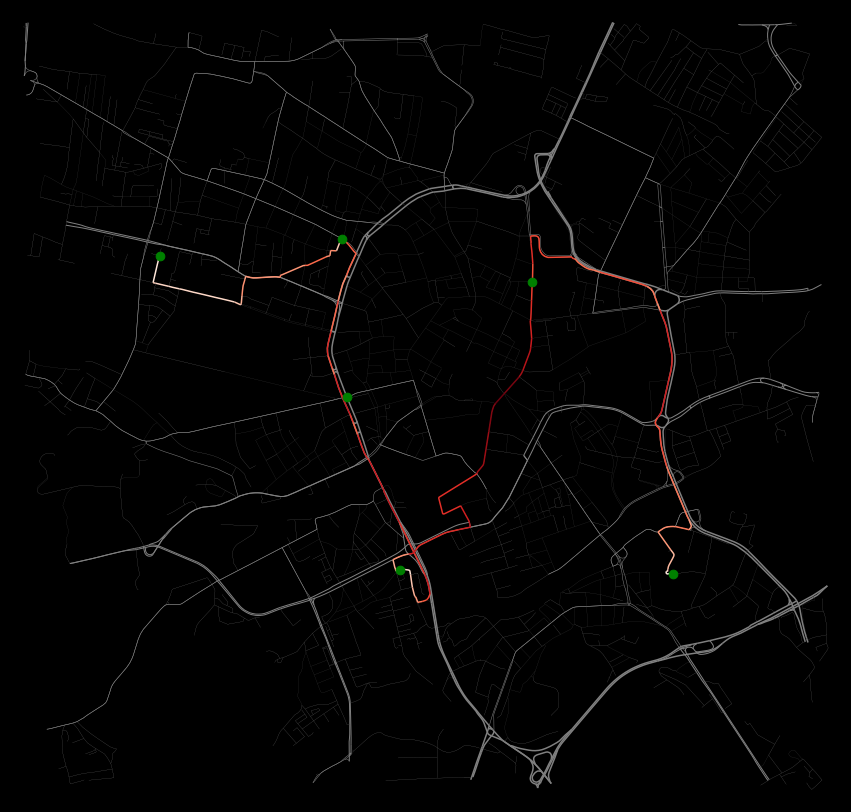

In [ ]:
fig, ax = ox.plot_graph_route(
    G,
    route,
    show=False,
    close=False,
    fig_height=15,
    fig_width=15,
    bgcolor="k",
    axis_off=True,
    node_size=0,
    node_edgecolor="gray",
    node_zorder=2,
    edge_color="gray",
    edge_linewidth=el,
    edge_alpha=1,
    route_color=rc,
    route_linewidth=1.5,
    route_alpha=1,
    orig_dest_node_size=0
)

for node in closest_nodes_geocodes:
    ax.scatter(node[0], node[1], c="g", s=75, alpha=1, zorder=3)

plt.show()